In [3]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
    shutil.rmtree('logs')
except:
    pass

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 21s 2us/step


In [22]:
def create_example(x,y):
    c=np.random.randint(0,2) # red or green no blue
    image = 0.5 * np.random.rand(28,28,3)
    image[:,:,c]+= 0.5 * x / 255.
    return image,y,c

In [6]:
x_train[0].shape


(28, 28)

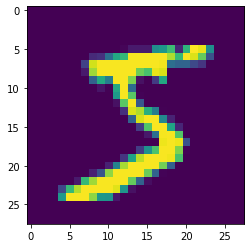

In [8]:
plt.imshow(x_train[0])
plt.show()

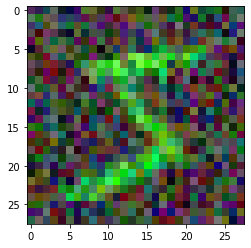

Color : green  Digit :  5


In [37]:
x,y,c = create_example(x_train[0],y_train[0])
plt.imshow(x)
plt.show()
colors = {0:'red',1:'green'}
print('Color :',colors[c],' Digit : ',y)

In [35]:
#db generator :
def generate_data(x,y,batch_size=32):
    num_examples=len(y)
    
    while True:
        x_batch = np.zeros((batch_size,28,28,3))
        y_batch = np.zeros((batch_size,))
        c_batch = np.zeros((batch_size,))
        
        for i in range(0,batch_size):
            index=np.random.randint(0,num_examples)
            image,digit,color = create_example(x[index],y[index])
            x_batch[i] = image
            y_batch[i] = digit
            c_batch[i] = color
        yield x_batch,[y_batch,c_batch]
        

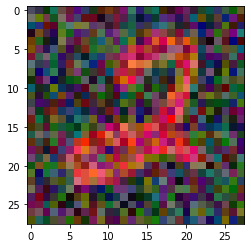

Color : red  Digit :  [2.]


In [40]:
x1, [y1,c1]=next(generate_data(x_test,y_test,batch_size=1))
plt.imshow(x1[0])
plt.show()
colors = {0:'red',1:'green'}
print('Color :',colors[c1[0]],' Digit : ',y1)

In [64]:
#Creating the model : we have two outputs : color and the label

from tensorflow.keras.layers import Input, Conv2D, Activation,MaxPool2D, Flatten,Add, Dense
from tensorflow.keras.models import Model

input_ = Input(shape=(28,28,3),name="input layer")

conv_1 = Conv2D(filters=32,kernel_size=3,name='conv_1')(input_)
act_1 = Activation(activation='relu',name='act_1')(conv_1)

pool_1 = MaxPool2D(pool_size=4,name='pool_1')(act_1)
flat_1 = Flatten(name='flat_1')(pool_1)

color = Dense(units=1,activation='sigmoid',name='color')(flat_1) #binary for color

conv_2= Conv2D(32,3,padding='same',name='conv_2')(act_1)#same activation
act_2=Activation('relu',name='act_2')(conv_2)

conv_3 = Conv2D(32,3,padding='same',name='conv_3')(act_2)
add= Add(name='add')([act_1,conv_3])
act_3 = Activation('relu',name='act_3')(add)

pool_2 = MaxPool2D(4,name='pool_2')(act_3)
flat_2 = Flatten(name='flat_2')(pool_2)

digit = Dense(10,activation='softmax',name='digit')(flat_2)

model = Model (input_, [digit,color]) # generate data returns the digit then the color

model.compile(
loss={
    
    'digit': 'sparse_categorical_crossentropy',
    'color':'binary_crossentropy'
},
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input layer (InputLayer)        [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 26, 26, 32)   896         input layer[0][0]                
__________________________________________________________________________________________________
act_1 (Activation)              (None, 26, 26, 32)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 26, 26, 32)   9248        act_1[0][0]                      
____________________________________________________________________________________________

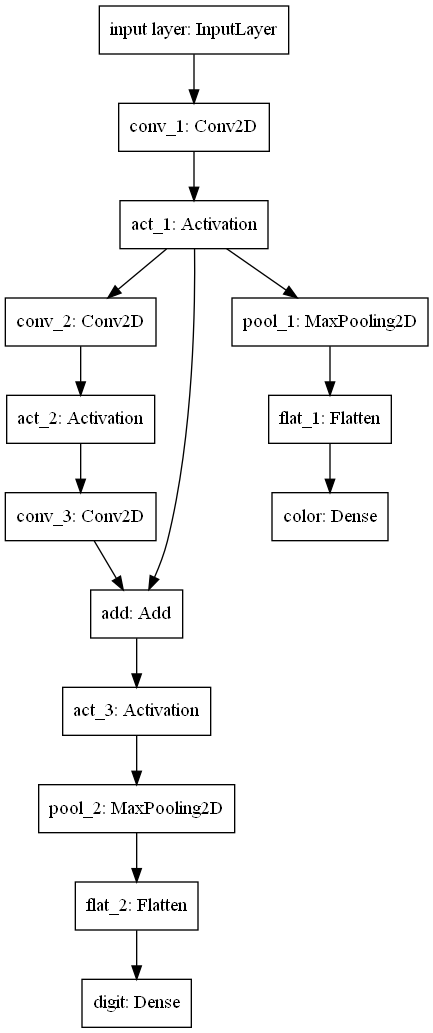

In [65]:
#plotting the model
from tensorflow.keras.utils import plot_model

plot_model(model)

In [66]:
class Logger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        digit_accuracy = logs.get('digit_accuracy')
        color_accuracy = logs.get('color_accuracy')
        val_digit_accuracy = logs.get('val_digit_accuracy')
        val_color_accuracy = logs.get('val_color_accuracy')
        print('='*30, epoch + 1, '='*30)
        print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
        print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')
    

In [69]:
#training the model
train_gen= generate_data(x_train,y_train)
test_gen = generate_data(x_test,y_test)

_ = model.fit(
    train_gen,
    validation_data=test_gen,
    steps_per_epoch=200,
    validation_steps=100,
    epochs=10,
    callbacks=[
        Logger(),
        tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ],
    verbose=False
)


============================== 1 ==============================
digit_accuracy: 0.97, color_accuracy: 1.00
val_digit_accuracy: 0.98, val_color_accuracy: 1.00
============================== 2 ==============================
digit_accuracy: 0.97, color_accuracy: 1.00
val_digit_accuracy: 0.97, val_color_accuracy: 1.00
============================== 3 ==============================
digit_accuracy: 0.98, color_accuracy: 1.00
val_digit_accuracy: 0.98, val_color_accuracy: 1.00
============================== 4 ==============================
digit_accuracy: 0.97, color_accuracy: 1.00
val_digit_accuracy: 0.97, val_color_accuracy: 1.00
============================== 5 ==============================
digit_accuracy: 0.97, color_accuracy: 1.00
val_digit_accuracy: 0.97, val_color_accuracy: 1.00
============================== 6 ==============================
digit_accuracy: 0.97, color_accuracy: 1.00
val_digit_accuracy: 0.98, val_color_accuracy: 1.00
============================== 7 ===================

In [70]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 19296), started 0:01:11 ago. (Use '!kill 19296' to kill it.)

In [122]:
def test_model(test,show=True):
    x, [y, c] = next(test)

    preds = model.predict(x)
    pred_digit = np.argmax(preds[0])
    pred_color = int(preds[1] > 0.5)
    gt_digit = int(y[0])
    gt_color = int(c[0])

    plt.imshow(x[0])
    if show:
        print(f'GT: {gt_digit}, {colors[gt_color]}')
        print(f'Pr: {pred_digit}, {colors[pred_color]}')
        plt.show()
    else:
        col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
        plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
        plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
        plt.xticks([])
        plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)

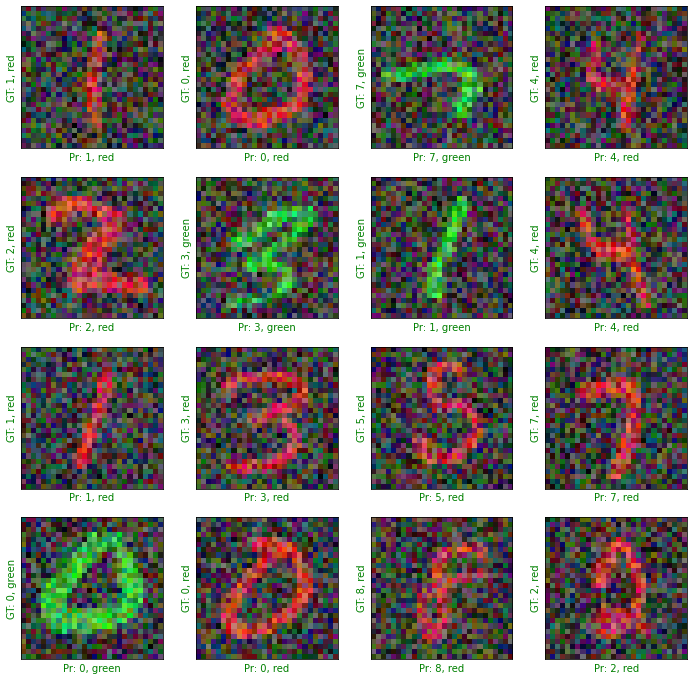

In [101]:
plt.figure(figsize=(12,12))

for i in range(0,16):
    plt.subplot(4,4,i+1) #subplots start from 1
    test_model(test,False)
plt.show()

In [184]:
def show_confusion_matrix_digit(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 10)), labels=classes)
    plt.yticks(list(range(0, 10)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
    

In [170]:
test = generate_data(x_test, y_test, batch_size=32)
x, [y, c] = next(test)
y_pred = list(np.argmax(model.predict(x)[0],axis=-1))
#print(y_pred)

y_true=list(y)
for i in range(10) :
    x, [y, c] = next(test)
    y_pred.extend(list(np.argmax(model.predict(x)[0],axis=-1)))
    y_true.extend(list(y))


352


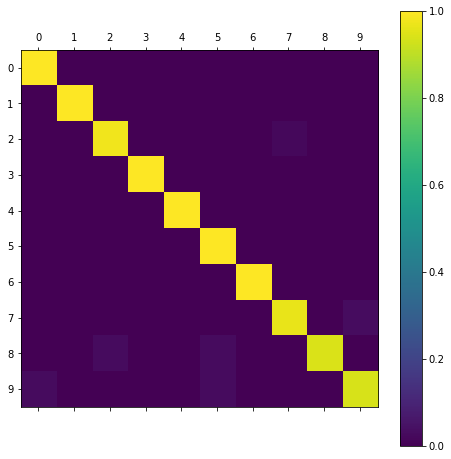

In [165]:
show_confusion_matrix_digit(y_true,y_pred,classes=[0,1,2,3,4,5,6,7,8,9])

In [185]:
def show_confusion_matrix_color(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 2)), labels=classes)
    plt.yticks(list(range(0, 2)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
    

In [186]:
test = generate_data(x_test, y_test, batch_size=32)
x, [y, c] = next(test)
y_pred = list(np.around(model.predict(x)[1]))
y_true=list(c)
for i in range(10) :
    x, [y, c] = next(test)
    y_pred.extend(list(np.around(model.predict(x)[1])))
    y_true.extend(list(c))


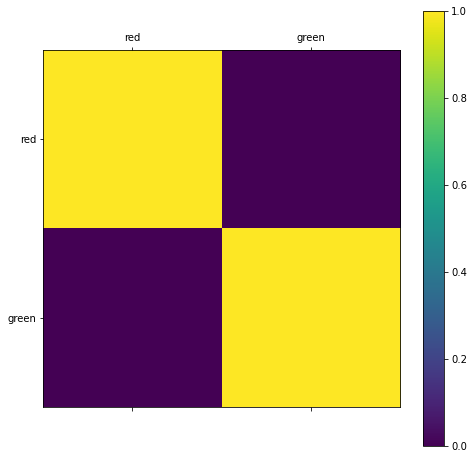

In [189]:
show_confusion_matrix_color(y_true,y_pred,classes=['red','green'])